<a href="https://colab.research.google.com/github/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation/blob/main/HeartSEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Git if not already installed
!apt-get install git -qq

# Configure Git with your info
!git config --global user.email "safinazmo7amed@gmail.com.com"
!git config --global user.name "Safinaz-Muhammad"

# Clone your GitHub repo (only once)
!git clone https://github.com/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation

Cloning into 'Task-1--Medical-Images-Segmentation'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (501/501), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 501 (delta 14), reused 501 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (501/501), 23.79 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here

# ========================
# 1. Setup Kaggle API
# ========================
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ========================
# 2. Download + unzip datasets
# ========================
!mkdir -p ./datasets/heart

# Heart CT dataset
!kaggle datasets download -d nikhilroxtomar/ct-heart-segmentation -p ./datasets/heart --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/ct-heart-segmentation
License(s): unknown
 95% 514M/541M [00:01<00:00, 345MB/s]
100% 541M/541M [00:02<00:00, 214MB/s]


In [ ]:
!pip install nibabel opencv-python scikit-image tensorflow matplotlib numpy pandas


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.2 MB/s eta 0:00:00


In [ ]:
# ========================
# 3. Imports
# ========================
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
# ========================
# 4. Preprocessing functions
# ========================
import pydicom

def load_and_preprocess_pil(image_path, target_size=(128,128)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    return np.array(img) / 255.0

def load_and_preprocess_mask_pil(mask_path, target_size=(128,128)):
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(target_size, Image.NEAREST)
    mask_array = np.array(mask)
    # Assuming mask values of 255 represent the heart (class 1) and others are background (class 0)
    mask_array = (mask_array > 0).astype(np.int32) # Cast to int32
    return mask_array


def load_and_preprocess_dcm(dcm_path, target_size=(128, 128)):
    dicom_data = pydicom.dcmread(dcm_path)
    # Assuming single frame DICOM image
    img = dicom_data.pixel_array
    # Normalize pixel values to 0-255
    img = img - np.min(img)
    img = img / np.max(img) * 255
    img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
    img = img.resize(target_size)
    return np.array(img) / 255.0

# ========================
# 5. Load heart dataset
# ========================
def load_heart_dataset(base_path="./datasets/heart/data"): # Updated path
    image_files = []
    mask_files = []
    for split in ["train", "test"]:
        split_dir = os.path.join(base_path, split)
        for case_dir in sorted(os.listdir(split_dir)):
          if split == "train":
            img_dir = os.path.join(split_dir, case_dir, "image")
            mask_dir = os.path.join(split_dir, case_dir, "mask")
            image_files.extend(sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith((".png",".jpg"))]))
            mask_files.extend(sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith((".png",".jpg"))]))
          elif split == "test":
            # Assuming the test data has one subdirectory per case containing dcm files
            nested_dir = os.path.join(split_dir, case_dir, os.listdir(os.path.join(split_dir, case_dir))[0])
            image_files.extend(sorted([os.path.join(nested_dir, f) for f in os.listdir(nested_dir) if f.endswith(".dcm")]))
            # There appear to be no masks for the test set in this dataset
            mask_files.extend([None] * len([f for f in os.listdir(nested_dir) if f.endswith(".dcm")]))


    images, masks = [], []
    for img_path, mask_path in zip(image_files, mask_files):
        if img_path.endswith((".png", ".jpg")):
          img = load_and_preprocess_pil(img_path)
        elif img_path.endswith(".dcm"):
          img = load_and_preprocess_dcm(img_path)
        images.append(img)
        masks.append(mask_path) # Keep mask_path for now, will handle None later


    # Separate train and test based on whether a mask exists
    train_images = [images[i] for i in range(len(images)) if mask_files[i] is not None]
    train_masks = [masks[i] for i in range(len(masks)) if mask_files[i] is not None]
    test_images = [images[i] for i in range(len(images)) if mask_files[i] is None]

    # Load the actual masks for the training set
    loaded_train_masks = []
    for mask_path in train_masks:
      loaded_train_masks.append(load_and_preprocess_mask_pil(mask_path))

    X_train = np.array(train_images)
    y_train = np.expand_dims(np.array(loaded_train_masks), -1)
    X_test = np.array(test_images)


    print(f"Heart dataset loaded:")
    print(f"  Train images: {X_train.shape[0]} samples")
    print(f"  Train masks: {y_train.shape[0]} samples")
    print(f"  Test images: {X_test.shape[0]} samples")

    # Returning train and test sets separately as test set has no masks
    return X_train, y_train, X_test

# Load dataset
X_train, y_train, X_test = load_heart_dataset()

Heart dataset loaded:
  Train images: 2532 samples
  Train masks: 2532 samples
  Test images: 832 samples


In [ ]:
# ========================
# 6. Train/Validation Split
# ========================
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# ========================
# 7. Metrics
# ========================
def dice_coefficient(y_true, y_pred, smooth=1):
    # y_true is already squeezed to (batch_size, 128, 128)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1):
    # y_true is already squeezed to (batch_size, 128, 128)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", dice_coefficient, iou_score]
    )
    return model

In [ ]:
# ========================
# 8. U-Net Model
# ========================
def simple_unet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    # Decoder
    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(b)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = layers.concatenate([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c4)
    return models.Model(inputs, outputs)



In [ ]:
# ========================
# 9. Train Model
# ========================
model = compile_model(simple_unet(input_size=X_train.shape[1:], num_classes=2))

# Remove the extra dimension from y_train and y_val
y_train_squeezed = np.squeeze(y_train, axis=-1)
y_val_squeezed = np.squeeze(y_val, axis=-1)


history = model.fit(X_train, y_train_squeezed, validation_data=(X_val, y_val_squeezed), epochs=10, batch_size=4)

# ========================
# 10. Visualize Predictions
# ========================
def visualize_heart_predictions(model, X, y, num_samples=5):
    preds = model.predict(X[:num_samples])
    preds_classes = np.argmax(preds, axis=-1)

    for i in range(num_samples):
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(preds_classes[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Visualize results
visualize_heart_predictions(model, X_val, y_val, num_samples=5)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 225s 430ms/step - accuracy: 0.9563 - dice_coefficient: 0.8995 - iou_score: 0.8335 - loss: 0.1782 - val_accuracy: 0.9680 - val_dice_coefficient: 0.9326 - val_iou_score: 0.8741 - val_loss: 0.1115
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 194s 382ms/step - accuracy: 0.9694 - dice_coefficient: 0.9445 - iou_score: 0.8955 - loss: 0.1006 - val_accuracy: 0.9683 - val_dice_coefficient: 0.9538 - val_iou_score: 0.9120 - val_loss: 0.0853
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 191s 376ms/step - accuracy: 0.9712 - dice_coefficient: 0.9553 - iou_score: 0.9149 - loss: 0.0787 - val_accuracy: 0.9777 - val_dice_coefficient: 0.9634 - val_iou_score: 0.9297 - val_loss: 0.0585
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 203s 379ms/step - accuracy: 0.9769 - dice_coefficient: 0.9654 - iou_score: 0.9334 - loss: 0.0601 - val_accuracy: 0.9813 - val_dice_coefficient: 0.9693 - val_iou_score: 0.9407 - val_loss: 0.0495
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 201s 378ms/step - accura

In [ ]:
import numpy as np

print("Unique values and data type in y_train:")
print(np.unique(y_train))
print(y_train.dtype)

print("\nUnique values and data type in y_val:")
print(np.unique(y_val))
print(y_val.dtype)

Unique values and data type in y_train:
[0 1]
int32

Unique values and data type in y_val:
[0 1]
int32


In [ ]:
!ls ./datasets/heart/data/test/100251

2-0OPAGELSQXD3602.5120nullnullnull-72944


In [ ]:
!ls -R ./datasets/heart/data

./datasets/heart/data:
test  train

./datasets/heart/data/test:
100251	100252	100253	100254	100256	100258

./datasets/heart/data/test/100251:
2-0OPAGELSQXD3602.5120nullnullnull-72944

./datasets/heart/data/test/100251/2-0OPAGELSQXD3602.5120nullnullnull-72944:
1-001.dcm  1-019.dcm  1-037.dcm  1-055.dcm  1-073.dcm  1-091.dcm  1-109.dcm
1-002.dcm  1-020.dcm  1-038.dcm  1-056.dcm  1-074.dcm  1-092.dcm  1-110.dcm
1-003.dcm  1-021.dcm  1-039.dcm  1-057.dcm  1-075.dcm  1-093.dcm  1-111.dcm
1-004.dcm  1-022.dcm  1-040.dcm  1-058.dcm  1-076.dcm  1-094.dcm  1-112.dcm
1-005.dcm  1-023.dcm  1-041.dcm  1-059.dcm  1-077.dcm  1-095.dcm  1-113.dcm
1-006.dcm  1-024.dcm  1-042.dcm  1-060.dcm  1-078.dcm  1-096.dcm  1-114.dcm
1-007.dcm  1-025.dcm  1-043.dcm  1-061.dcm  1-079.dcm  1-097.dcm  1-115.dcm
1-008.dcm  1-026.dcm  1-044.dcm  1-062.dcm  1-080.dcm  1-098.dcm  1-116.dcm
1-009.dcm  1-027.dcm  1-045.dcm  1-063.dcm  1-081.dcm  1-099.dcm  1-117.dcm
1-010.dcm  1-028.dcm  1-046.dcm  1-064.dcm  1-082.dcm  1

In [ ]:
!ls ./datasets/heart/data/train/100051

image  mask


In [ ]:
!ls ./datasets/heart/data/train

100051	100056	100065	100069	100073	100079	100082	100091	100093	100095
100053	100058	100067	100072	100075	100080	100089	100092	100094


In [ ]:
!ls ./datasets/heart/data

test  train


In [ ]:
!ls ./datasets/heart

data


In [ ]:
# ========================
# Interactive 3D Heart Visualization (U-Net predictions)
# ========================
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D

# ------------------------
# 1. Function to visualize heart in 3D
# ------------------------
def visualize_3d_heart(volume, class_colors=None, alpha=0.6):
    """
    volume: 3D numpy array (slices, H, W) with integer labels
    class_colors: dictionary {label: color}, e.g. {0:'gray', 1:'red', 2='blue', 3='green'}
    alpha: transparency
    """
    if class_colors is None:
        unique_labels = np.unique(volume)
        colors = plt.cm.get_cmap("tab20", len(unique_labels))
        class_colors = {label: colors(i) for i, label in enumerate(unique_labels)}

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Find unique labels in the volume
    volume_labels = np.unique(volume)

    for label, color in class_colors.items():
        if label == 0:  # skip background
            continue

        # Check if the current label exists in the volume
        if label not in volume_labels:
            print(f"Label {label} not found in the volume. Skipping visualization for this label.")
            continue

        # Extract the surface for the current label
        # Cast to float to make the level 0.5 meaningful for marching_cubes
        verts, faces, _, _ = measure.marching_cubes((volume==label).astype(float), level=0.5, step_size=2) # Added step_size for performance

        # Check if marching_cubes returned any vertices (i.e., if a surface was found)
        if verts.shape[0] == 0:
            print(f"No surface found for label {label}. Skipping visualization for this label.")
            continue


        ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2],
                        color=color, lw=0.5, alpha=alpha)

    ax.set_box_aspect([1,1,1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("3D Heart Segmentation")

    # Interactive rotation
    ax.view_init(elev=30, azim=30)
    plt.show()

In [ ]:
# ------------------------
# 2. Prepare the full heart volume
# ------------------------
# Predict on validation set
preds = model.predict(X_val)   # shape: (N_slices, H, W, num_classes)
preds_classes = np.argmax(preds, axis=-1)     # shape: (N_slices, H, W)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step


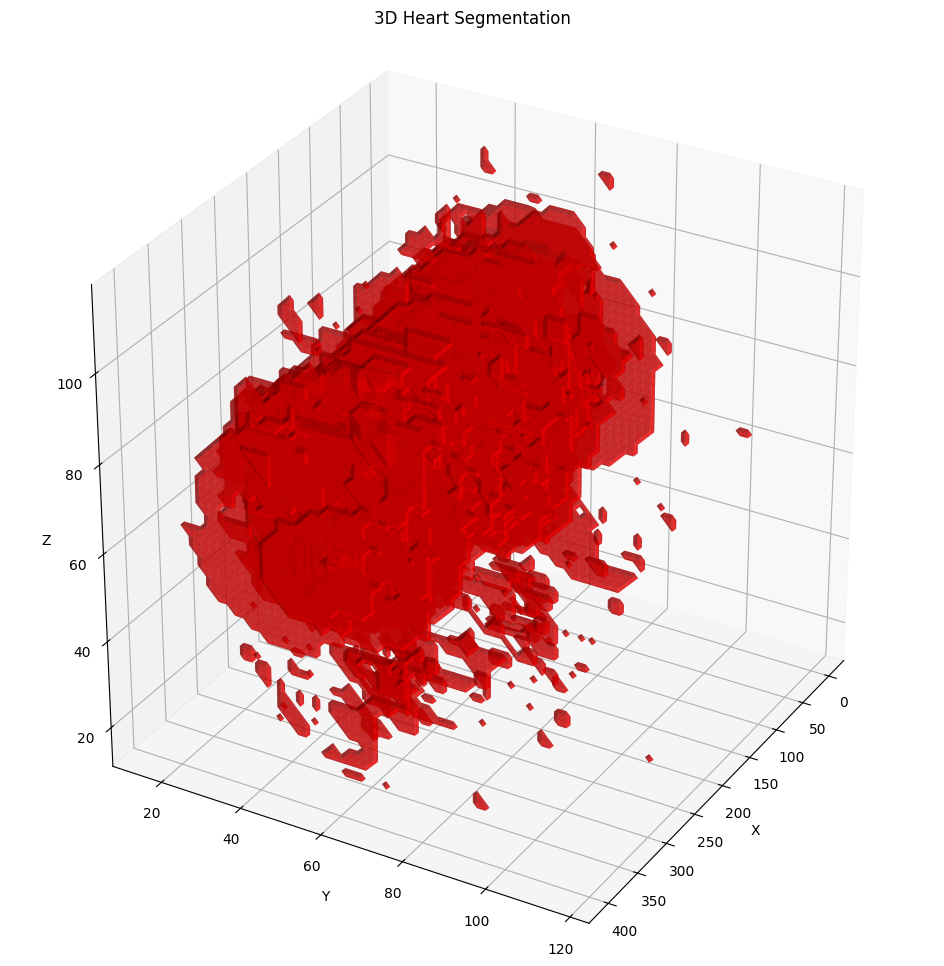

In [ ]:
# Use all slices
heart_volume_3d = preds_classes  # (all slices, H, W)

# ------------------------
# 3. Define colors for heart parts
# ------------------------
# Example: 1=LV, 2=RV, 3=myocardium (adjust according to your labels)
# Since the model predicts only 0 and 1, we only need a color for label 1
heart_colors = {0:'gray', 1:'red'}

# ------------------------
# 4. Visualize
# ------------------------
visualize_3d_heart(heart_volume_3d, class_colors=heart_colors, alpha=0.6)

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 800ms/step
Visualizing test set predictions:


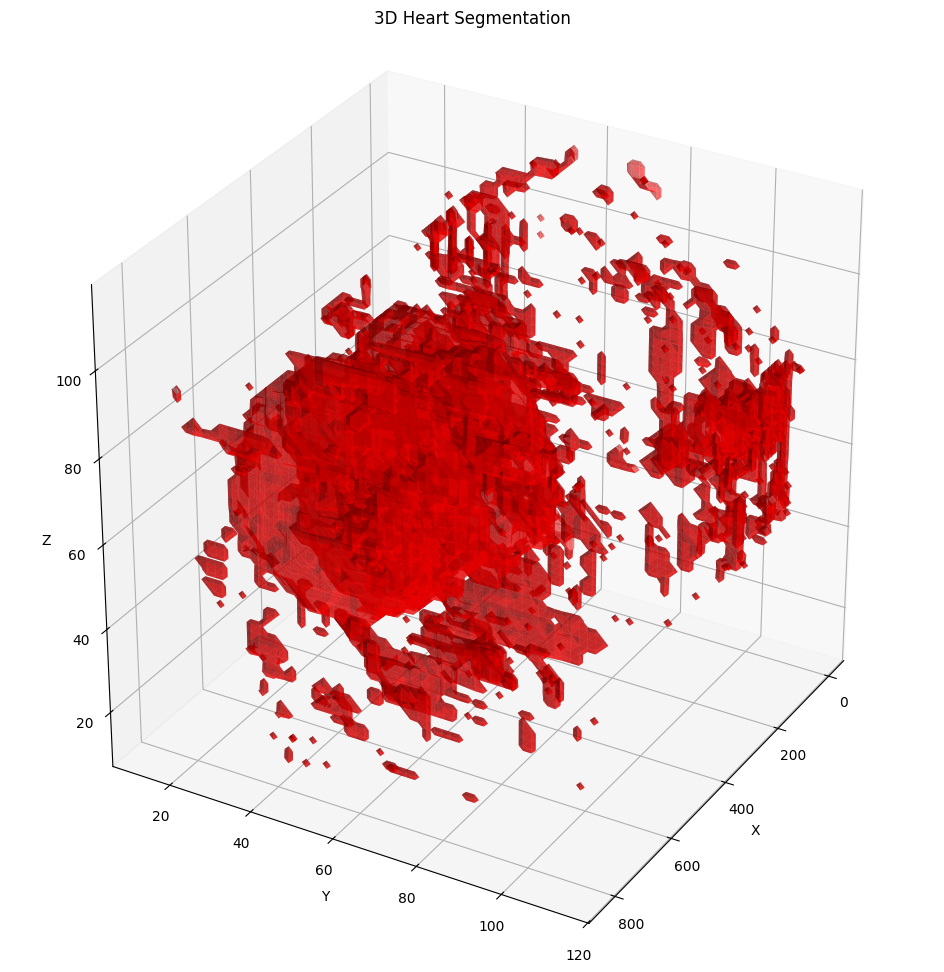

In [ ]:
# ========================
# 11. Predict and Visualize on Test Set
# ========================
import matplotlib.pyplot as plt # Added import

# Predict on the test set
test_preds = model.predict(X_test)
test_preds_classes = np.argmax(test_preds, axis=-1)

# Visualize test set predictions (only predicted masks, no ground truth)
print("Visualizing test set predictions:")
# You can choose which visualization function to use here (matplotlib or vedo)
# Using the matplotlib function for simplicity here
visualize_3d_heart(test_preds_classes, class_colors={0:'gray', 1:'red'}, alpha=0.6) # Assuming only label 1 (heart) is relevant


Training History Metrics:


,accuracy,dice_coefficient,iou_score,loss,val_accuracy,val_dice_coefficient,val_iou_score,val_loss
0,0.968901,0.928108,0.871040,0.139176,0.969837,0.941935,0.890746,0.108043
1,0.969683,0.945442,0.897124,0.103335,0.969837,0.952626,0.909954,0.089035
2,0.970155,0.950606,0.906351,0.089683,0.970407,0.959598,0.922789,0.080923
3,0.972865,0.957966,0.919815,0.074604,0.976229,0.965541,0.933707,0.063396
4,0.976395,0.964126,0.931108,0.062425,0.978401,0.971154,0.944289,0.057452
5,0.978770,0.968148,0.938573,0.054694,0.980371,0.972297,0.946330,0.050944
6,0.980909,0.971179,0.944236,0.049957,0.980864,0.969335,0.940735,0.052961
7,0.982476,0.973536,0.948640,0.045625,0.983773,0.974334,0.950124,0.041615
8,0.983932,0.975959,0.953265,0.041351,0.985932,0.980516,0.961950,0.037668
9,0.985101,0.977573,0.956324,0.038714,0.987029,0.978396,0.957864,0.034520


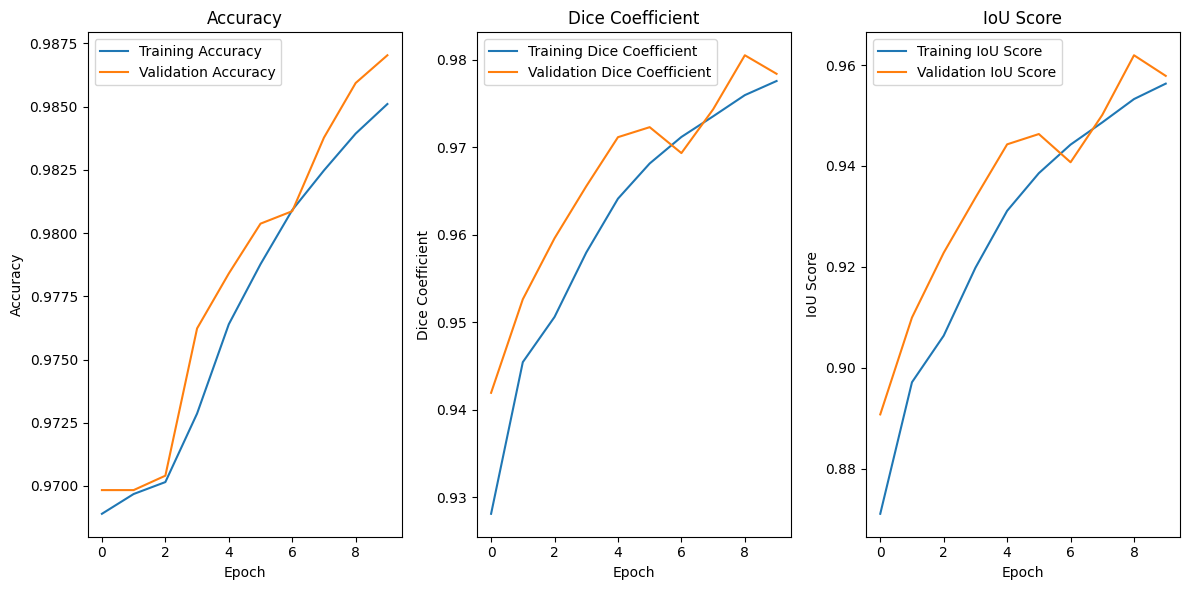

from matplotlib import pyplot as plt
history_df['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df['dice_coefficient'].plot(kind='hist', bins=20, title='dice_coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df['iou_score'].plot(kind='hist', bins=20, title='iou_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df.plot(kind='scatter', x='accuracy', y='dice_coefficient', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df.plot(kind='scatter', x='dice_coefficient', y='iou_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df.plot(kind='scatter', x='iou_score', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history_df.plot(kind='scatter', x='loss', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history_df.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['val_dice_coefficient']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history_df.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('val_dice_coefficient')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['val_iou_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history_df.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('val_iou_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history_df.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
history_df['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history_df['dice_coefficient'].plot(kind='line', figsize=(8, 4), title='dice_coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history_df['iou_score'].plot(kind='line', figsize=(8, 4), title='iou_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history_df['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ========================
# 12. Display Training History Metrics
# ========================
import pandas as pd
import matplotlib.pyplot as plt # Added import

print("\nTraining History Metrics:")
history_df = pd.DataFrame(history.history)
display(history_df)

# Optional: Plot the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['iou_score'], label='Training IoU Score')
plt.plot(history.history['val_iou_score'], label='Validation IoU Score')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ========================
# 1️⃣ Import libraries
# ========================
import os
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from vedo import Plotter, Volume
from scipy.ndimage import label

# ========================
# 2️⃣ Load heart dataset
# ========================
# Assume you have X_heart, y_heart loaded already (images and masks)
# X_heart: (N,H,W,3), y_heart: (N,H,W,1) with 0=background,1=heart

# Example split
# X_train, X_val, y_train, y_val = train_test_split(X_heart, y_heart, test_size=0.2, random_state=42)

# ========================
# 3️⃣ Build SegNet model
# ========================
def simple_segnet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
    return models.Model(inputs, outputs)

# ========================
# 4️⃣ Compile model
# ========================
segnet_heart = simple_segnet(input_size=X_train.shape[1:], num_classes=2)
segnet_heart.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
segnet_heart.summary()

# ========================
# 5️⃣ Train model
# ========================
# Remove the extra dimension from y_train and y_val for sparse_categorical_crossentropy
y_train_squeezed = np.squeeze(y_train, axis=-1)
y_val_squeezed = np.squeeze(y_val, axis=-1)

history = segnet_heart.fit(
    X_train, y_train_squeezed,  # Use squeezed labels for training
    validation_data=(X_val, y_val_squeezed), # Use squeezed labels for validation
    epochs=5,
    batch_size=4
)

# ========================
# 6️⃣ Evaluate predictions
# ========================
preds = segnet_heart.predict(X_val)
preds_classes = np.argmax(preds, axis=-1)  # (N,H,W)

# Visualize a few 2D predictions
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(X_val[i]); plt.title("Heart Image")
    plt.subplot(1,3,2); plt.imshow(y_val[i].squeeze()); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(preds_classes[i]); plt.title("Prediction")
    plt.show()




Heart SegNet Training History Metrics:


,accuracy,loss,val_accuracy,val_loss
0,0.967711,0.131724,0.969837,0.111505
1,0.969690,0.097767,0.969838,0.092764
2,0.972740,0.074826,0.975523,0.064468
3,0.976991,0.061360,0.979208,0.055839
4,0.979200,0.056085,0.978247,0.055230


Dice Coefficient not found in training history.
IoU Score not found in training history.


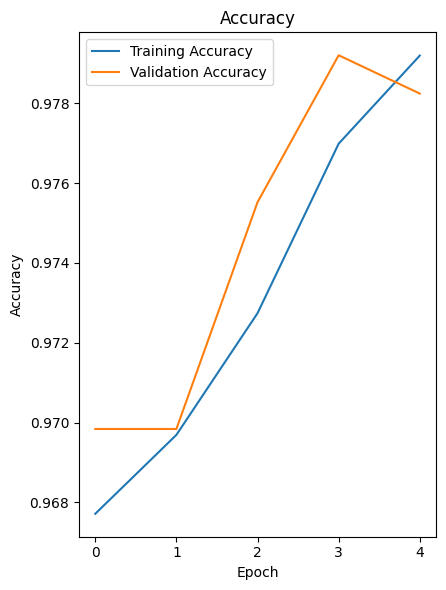

In [ ]:
# ========================
# Display Heart SegNet Training Metrics
# ========================
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `history` is the History object returned by model.fit()
print("\nHeart SegNet Training History Metrics:")
heart_history_df = pd.DataFrame(history.history) # Changed heart_history to history
display(heart_history_df)

# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Dice Coefficient
# Check if 'dice_coefficient' is in history.history keys before plotting
if 'dice_coefficient' in history.history:
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
else:
    print("Dice Coefficient not found in training history.")


# IoU Score
# Check if 'iou_score' is in history.history keys before plotting
if 'iou_score' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_score'], label='Training IoU Score')
    plt.plot(history.history['val_iou_score'], label='Validation IoU Score')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
else:
    print("IoU Score not found in training history.")


plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# ---------------------------
# 1. Metrics
# ---------------------------
def dice_coefficient(y_true, y_pred, smooth=1):
    # y_true shape: (batch_size, H, W) - class indices
    # y_pred shape: (batch_size, H, W, num_classes) - softmax output

    # Get predicted class indices
    y_pred_classes = K.argmax(y_pred, axis=-1) # shape: (batch_size, H, W)

    # Flatten true and predicted class indices
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred_classes, tf.float32))

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    # y_true shape: (batch_size, H, W) - class indices
    # y_pred shape: (batch_size, H, W, num_classes) - softmax output

    # Get predicted class indices
    y_pred_classes = K.argmax(y_pred, axis=-1) # shape: (batch_size, H, W)

    # Flatten true and predicted class indices
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred_classes, tf.float32))

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# ---------------------------
# 2. Compile Model (Assuming this is for the U-Net defined earlier)
# ---------------------------
# Re-compile the model with the defined metrics
# Assuming 'model' variable holds the U-Net model from cell '_vS3sOgYyDYs'
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for 2 classes and softmax output
              metrics=['accuracy', dice_coefficient, iou_score])

# ---------------------------
# 3. Train Model
# ---------------------------
# Use the existing numpy arrays for training and validation
# Ensure y_train and y_val are squeezed to remove the last dimension
y_train_squeezed = np.squeeze(y_train, axis=-1)
y_val_squeezed = np.squeeze(y_val, axis=-1)

history = model.fit(X_train, y_train_squeezed,
                    validation_data=(X_val, y_val_squeezed),
                    epochs=10, # Reduced epochs for quicker execution
                    batch_size=4) # Using batch_size 4 as in previous successful training

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 163s 390ms/step - accuracy: 0.9856 - dice_coefficient: 0.6228 - iou_score: 0.5096 - loss: 0.0379 - val_accuracy: 0.9857 - val_dice_coefficient: 0.6296 - val_iou_score: 0.5212 - val_loss: 0.0367
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 156s 385ms/step - accuracy: 0.9866 - dice_coefficient: 0.6624 - iou_score: 0.5527 - loss: 0.0345 - val_accuracy: 0.9862 - val_dice_coefficient: 0.6136 - val_iou_score: 0.4951 - val_loss: 0.0358
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 200s 381ms/step - accuracy: 0.9860 - dice_coefficient: 0.6191 - iou_score: 0.5091 - loss: 0.0365 - val_accuracy: 0.9864 - val_dice_coefficient: 0.6116 - val_iou_score: 0.4968 - val_loss: 0.0350
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 153s 377ms/step - accuracy: 0.9884 - dice_coefficient: 0.6620 - iou_score: 0.5623 - loss: 0.0302 - val_accuracy: 0.9850 - val_dice_coefficient: 0.6260 - val_iou_score: 0.5056 - val_loss: 0.0421
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 154s 380ms/step - accura

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # or another segmentation loss
              metrics=['accuracy', dice_coefficient, iou_score])


In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    batch_size=8)


NameError: name 'train_dataset' is not defined